# Computational Intelligence for Optimization Project

Sports League Optimization

Project developed by:
- Afonso Ascensão, 20240684
- Diogo Rodrigues, 
- Inês Jacinto, 20240536
- Maria Assunção, 20211605

Group B
Spring Semester, 2024/2025

# Imports & Libraries

In [22]:
import sys
sys.path.append('..')
import random
import numpy as np
import pandas as pd
from copy import deepcopy
from collections import Counter
from collections import defaultdict
import matplotlib.pyplot as plt
from tqdm import tqdm
import copy
import math

# Load the Data

In [23]:
# loading players data from excel file
df = pd.read_excel('players.xlsx')

# extracting players to a list data for easier manipulation later on
players = []
for _, row in df.iterrows():
    players.append((row['Name'], row['Position'], row['Skill'], row['Salary (â‚¬M)']))

In [24]:
df = pd.DataFrame(players, columns=['Player Name', 'Position', 'Rating', 'Cost'])
print(df)

         Player Name Position  Rating  Cost
0        Alex Carter       GK      85    90
1       Jordan Smith       GK      88   100
2      Ryan Mitchell       GK      83    85
3     Chris Thompson       GK      80    80
4    Blake Henderson       GK      87    95
5      Daniel Foster      DEF      90   110
6      Lucas Bennett      DEF      85    90
7        Owen Parker      DEF      88   100
8       Ethan Howard      DEF      80    70
9         Mason Reed      DEF      82    75
10      Logan Brooks      DEF      86    95
11      Caleb Fisher      DEF      84    85
12     Nathan Wright      MID      92   120
13      Connor Hayes      MID      89   105
14      Dylan Morgan      MID      91   115
15     Hunter Cooper      MID      83    85
16     Austin Torres      MID      82    80
17  Gavin Richardson      MID      87    95
18      Spencer Ward      MID      84    85
19   Sebastian Perry      FWD      95   150
20     Xavier Bryant      FWD      90   120
21    Elijah Sanders      FWD   

# Problem Definition

``Sports League Optimization``

**Objective** - Assign  players  to  teams according to specified positions in  a  way  that  ensures a balanced distribution of talent while staying within salary caps and position constraints. (5 teams, 7 players each)

**Players** - Defined by a set of attributes that include:
- Name: Unique entry of the players' name.
- Skill rating: Represents the player's ability/talent. 
- Cost: The player's salary (in millions). 
- Position: Goalkeeper  (GK),  Defender  (DEF),  Midfielder  (MID),  or Forward (FWD). 

**Constraints** - An object is considered a solution if it complies with these conditions:
- Each team must consist of: 1 Goalkeeper, 2 Defenders, 2 Midfielders and 2 Forwards. 
- Each player is assigned to exactly one team.
- All teams must be complete.
- Each team should not exceed a 750€ million total budget. 
- The average skill rating of the players should be roughly the same among the teams.

**Individual:** An individual in the context of this project is a complete league configuration that respects all constraints defined above.

**Minimization Problem:** The problem at hand is a minimization problem as we are trying to find the solution that minimizes imbalance between teams according to the standard deviation of each teams average skill rating.

*Note: The raw number of possible configurations, without adhering to budget and skill constraints, for the league is 479 billion.*

# Data Exploration

In [25]:
print(f"This dataset contains {len(df)} players.")
players

This dataset contains 35 players.


[('Alex Carter', 'GK', 85, 90),
 ('Jordan Smith', 'GK', 88, 100),
 ('Ryan Mitchell', 'GK', 83, 85),
 ('Chris Thompson', 'GK', 80, 80),
 ('Blake Henderson', 'GK', 87, 95),
 ('Daniel Foster', 'DEF', 90, 110),
 ('Lucas Bennett', 'DEF', 85, 90),
 ('Owen Parker', 'DEF', 88, 100),
 ('Ethan Howard', 'DEF', 80, 70),
 ('Mason Reed', 'DEF', 82, 75),
 ('Logan Brooks', 'DEF', 86, 95),
 ('Caleb Fisher', 'DEF', 84, 85),
 ('Nathan Wright', 'MID', 92, 120),
 ('Connor Hayes', 'MID', 89, 105),
 ('Dylan Morgan', 'MID', 91, 115),
 ('Hunter Cooper', 'MID', 83, 85),
 ('Austin Torres', 'MID', 82, 80),
 ('Gavin Richardson', 'MID', 87, 95),
 ('Spencer Ward', 'MID', 84, 85),
 ('Sebastian Perry', 'FWD', 95, 150),
 ('Xavier Bryant', 'FWD', 90, 120),
 ('Elijah Sanders', 'FWD', 93, 140),
 ('Adrian Collins', 'FWD', 85, 90),
 ('Tyler Jenkins', 'FWD', 80, 70),
 ('Chase Murphy', 'FWD', 86, 95),
 ('Landon Powell', 'FWD', 89, 110),
 ('Julian Scott', 'FWD', 92, 130),
 ('Bentley Rivera', 'MID', 88, 100),
 ('Maxwell Flores'

In [26]:
num_duplicates = df.duplicated().sum()
print(f"There are {num_duplicates} duplicate rows. All players are unique.")

There are 0 duplicate rows. All players are unique.


In [27]:
print(f"There are {df['Position'].nunique()} unique positions in the dataset.")
df['Position'].value_counts()

There are 4 unique positions in the dataset.


DEF    10
MID    10
FWD    10
GK      5
Name: Position, dtype: int64

In [28]:
df['Rating'].describe()

count    35.000000
mean     86.400000
std       4.095909
min      79.000000
25%      83.500000
50%      86.000000
75%      89.500000
max      95.000000
Name: Rating, dtype: float64

Player ratings vary from 79 to 95. The average rating is 86.4.

In [29]:
df['Cost'].describe()

count     35.000000
mean      97.828571
std       19.876805
min       65.000000
25%       85.000000
50%       95.000000
75%      110.000000
max      150.000000
Name: Cost, dtype: float64

Players costs vary from 65€ million to 150€ million. The average cost for a player is ~98€ million.

# Solution Implementation

##### ``Constants``

In [30]:
# Constants
NUM_TEAMS = 5
PLAYERS_PER_TEAM = 7
MAX_BUDGET = 750 # units are million €
POSITIONS = ["GK", "DEF", "MID", "FWD"]
POSITION_REQUIREMENTS = {"GK": 1, "DEF": 2, "MID": 2, "FWD": 2}

##### ``Solution Class (League Configuration)``

In [ ]:
class TeamAssignmentSolution:
    def __init__(self, players, population=None):
        self.players = players  # list of players
        self.population = population if population else {} # a population should be a full valid league configuration 

    def random_initial_representation(self, max_attempts=1000):
        """Creates a random valid team assignment configuration."""
        for attempt in range(max_attempts):
            teams = {i: {"GK": [], "DEF": [], "MID": [], "FWD": [], "total_cost": 0} for i in range(NUM_TEAMS)}
            assigned_players = set() # using a set (unordered collection of unique elements) for efficient tracking of players already assigned
            shuffled_players = random.sample(self.players, len(self.players)) # initially shuffles players to ensure variability

            for player in shuffled_players:
                name, position, skill, cost = player
                for team_id in sorted(teams, key=lambda tid: teams[tid]["total_cost"]):
                    team = teams[team_id]
                    if len(team[position]) < POSITION_REQUIREMENTS[position] and team["total_cost"] + cost <= MAX_BUDGET:
                        team[position].append(player)
                        team["total_cost"] += cost
                        assigned_players.add(name)
                        break  # move to next player
                # if a player is not able to be assigned, even after the select number of max attempts, we do nothing and will check validity of solution below

            # validation
            valid_teams = True
            for team in teams.values():
                total_players = sum(len(team[pos]) for pos in POSITION_REQUIREMENTS)
                if total_players != PLAYERS_PER_TEAM: # if the number of players in a team is different than 7, team is invalid
                    valid_teams = False
                    break
                for pos, required_count in POSITION_REQUIREMENTS.items():
                    if len(team[pos]) != required_count: # if the number of players per position is not correspondent to the requirements, team is invalid
                        valid_teams = False
                        break

            if valid_teams and len(assigned_players) == len(self.players): # if all teams are valid then we have a complete league configuration
                self.population = teams
                return self.population # returns a valid league configuration

        raise ValueError("Failed to generate a valid team assignment after many attempts.") # logging if a valid configuration cannot be assigned

    def fitness(self):
        """Evaluate team's total skill rating: lower standard deviation of average skill means better balance."""
        if not self.population:
            raise ValueError("Population not initialized. Run random_initial_representation() first.") # logging if population is not initialzed

        team_avg_skills = []

        for team in self.population.values():
            total_skill = 0
            total_players = 0
            for position in POSITION_REQUIREMENTS:
                for player in team[position]:
                    total_skill += player[2]  # skill is the 3rd attribute (index 2) in the players list
                    total_players += 1
            avg_skill = total_skill / total_players 
            team_avg_skills.append(avg_skill)

        return np.std(team_avg_skills)  # returns standard deviation of all the teams average skill ratings - lower std indicates teams are better balanced

    def print_teams(self):
        """Auxiliary Method: Prints a summary of a complete league configuration's teams and setup for easy consultation."""
        for i, team in self.population.items():
            total_skill = 0
            total_players = 0

            for position in POSITIONS:
                total_skill += sum(player[2] for player in team[position])
                total_players += len(team[position])

            avg_skill = total_skill / total_players if total_players > 0 else 0

            print(f"\nTeam {i + 1} (Total Cost: {team['total_cost']}M, Average Skill: {avg_skill:.2f})")
            for position in POSITIONS:
                for player in team[position]:
                    name, pos, skill, cost = player
                    print(f"  {name} - {pos} | Skill: {skill}, Cost: {cost}M")

    def clone(self):
        """Creates a deep clone the instance and its population to ensure proper manipulation."""
        clone = TeamAssignmentSolution(self.players)
        clone.population = copy.deepcopy(self.population)
        return clone

    def get_players_and_teams_df(self):
        """Auxiliary Method: Creates a df with the final setup of a population including their assigned teams."""
        player_data = []
        
        for team_id, team in self.population.items(): # iterating through players and their respective teams
            for position in POSITIONS:
                for player in team[position]:
                    name, position, skill, cost = player
                    team_name = f"Team {team_id + 1}"  
                    
                    player_data.append({
                        "Name": name,
                        "Skill": skill,
                        "Position": position,
                        "Salary": cost,
                        "Assigned Team": team_name
                    })
        
        df = pd.DataFrame(player_data) # converting players list to a df
        return df
    


In [32]:
# calling the class to test it
solution = TeamAssignmentSolution(players)
solution.random_initial_representation() 

{0: {'GK': [('Ryan Mitchell', 'GK', 83, 85)],
  'DEF': [('Maxwell Flores', 'DEF', 81, 72),
   ('Brayden Hughes', 'DEF', 87, 100)],
  'MID': [('Dominic Bell', 'MID', 86, 95), ('Connor Hayes', 'MID', 89, 105)],
  'FWD': [('Chase Murphy', 'FWD', 86, 95), ('Xavier Bryant', 'FWD', 90, 120)],
  'total_cost': 672},
 1: {'GK': [('Alex Carter', 'GK', 85, 90)],
  'DEF': [('Daniel Foster', 'DEF', 90, 110), ('Caleb Fisher', 'DEF', 84, 85)],
  'MID': [('Ashton Phillips', 'MID', 90, 110),
   ('Nathan Wright', 'MID', 92, 120)],
  'FWD': [('Colton Gray', 'FWD', 91, 125), ('Landon Powell', 'FWD', 89, 110)],
  'total_cost': 750},
 2: {'GK': [('Blake Henderson', 'GK', 87, 95)],
  'DEF': [('Logan Brooks', 'DEF', 86, 95), ('Lucas Bennett', 'DEF', 85, 90)],
  'MID': [('Austin Torres', 'MID', 82, 80),
   ('Bentley Rivera', 'MID', 88, 100)],
  'FWD': [('Elijah Sanders', 'FWD', 93, 140),
   ('Julian Scott', 'FWD', 92, 130)],
  'total_cost': 730},
 3: {'GK': [('Chris Thompson', 'GK', 80, 80)],
  'DEF': [('Jaxon

##### ``Fitness``

In optimization problems, "fitness" is a measure of how good the solution is based on certain criteria. For our approach, we will assess fitness based on the average skill rating of the players on the 5 teams. This will be stored as their skill rating's standard deviation and from now on we intend on gradually improving our teams by swapping players between them to decrease the fitness score, which represents a minimization problem.

In [33]:
# evaluating the fitness of the initial population with the fitness method of our main class
fitness_score = solution.fitness()
print(f"Fitness Score: {fitness_score}")

Fitness Score: 1.5685688264355166


# Selection Mechanism

``Selection Mechanisms`` play a crucial role in determining which solutions will be passed on to the next generation for our evolutionary algorithm. In this context, it is responsible for choosing which team assignments should undergo further modification to evolve to better solutions. The best solutions will be more likely to be retained and refined, while less optimal solutions are less likely to survive. The mechanisms that will be tested are ranking and tournament selection.

##### `Ranking Selection`

The solutions with better fitness (lower fitness scores since this is a minimization problem) should be selected more frequently, as their ranks will be higher. It will select individuals for reproduction based on their relative rank in the population, according to a calculated weighted probability (where higher ranks have a better chance at being selected) rather than their raw fitness scores.

In [34]:
def ranking_selection(population: list):
    """Implements ranking selection with fitness-based sorting and rank-weighted probabilities."""

    # sorting population of solutions
    sorted_population = sorted(population, key=lambda ind: ind.fitness(), reverse=False) # ascending order → lowest fitness first

    # assigning ranks to solutions
    ranks = list(range(len(sorted_population), 0, -1))  # higher rank = higher selection chance

    # converting ranks to probabilities 
    total_rank = sum(ranks)
    probabilities = [rank / total_rank for rank in ranks]

    # selecting logic - spinning wheel approach (there are slices of proportional cumulative probabilities for each solution)
    random_nr = random.uniform(0, 1)
    cumulative_prob = 0

    for idx, prob in enumerate(probabilities):
        cumulative_prob += prob
        if random_nr <= cumulative_prob:
            return deepcopy(sorted_population[idx]) # returns the selection solution

##### `Tournament Selection`

This approach is simple, efficient and more robust to outliers than others. It’s based on the idea of "fighting it out" in small groups — the best among a randomly chosen subset wins. It picks a k set of individuals, compares their fitness and selects the best. Since the individuals to compete are randomly chosen, the frequency distribution will depend on the tournament size and randomness of the selections.

In [35]:
def tournament_selection(population: list, tournament_size: int = 3):
    """Implements tournament selection in a subset of 3 solutions."""

    # get a subset of individuals
    tournament_individuals = random.sample(population, tournament_size)

    # sort the tournament individuals by fitness (lowest is better)
    best_individual = min(tournament_individuals, key=lambda ind: ind.fitness())  

    return deepcopy(best_individual)  # returns the best individual

##### `Selection Results`

This section is intended to test how our selection mechanisms work and compare them against each other. This will provide us helpful insights into how to further apply them in our GA Loop. We will generate a population of randomly initialized league configurations and test how many times they are selected according to their fitness. This helpes us understand if our functions were working correctly, which meant that they would choose solutions with lower fitness (minimization) more often. We ran this over 100 selections attemps to get a good overview.

In [36]:
def test_selection():
    """Assess results of selection mechanisms implementations."""

    # creating a small population of valid solutions
    population = [TeamAssignmentSolution(players) for _ in range(10)]

    # initializing every solution and assessing fitness
    for i, solution in enumerate(population):
        solution.random_initial_representation()
        print(f"Solution {i+1} - Fitness: {solution.fitness()}")

    # running the selection process multiple times using both methods
    ranking_selected_solutions = [ranking_selection(population) for _ in range(100)]
    tournament_selected_solutions = [tournament_selection(population) for _ in range(100)]

    # keep track of how many times each fitness was selected
    ranking_fitness_counter = Counter([solution.fitness() for solution in ranking_selected_solutions])
    tournament_fitness_counter = Counter([solution.fitness() for solution in tournament_selected_solutions])

    # checking selection frequency results
    print("\nRanking Selection Frequency (100 Selections):")
    for fitness, count in ranking_fitness_counter.items():
        print(f"Fitness {fitness}: Selected {count} times")

    print("\nTournament Selection Frequency (100 Selections):")
    for fitness, count in tournament_fitness_counter.items():
        print(f"Fitness {fitness}: Selected {count} times")

# test
test_selection()

Solution 1 - Fitness: 0.5299210568854691
Solution 2 - Fitness: 0.6350317363112233
Solution 3 - Fitness: 1.3474086997201802
Solution 4 - Fitness: 1.2629734917314466
Solution 5 - Fitness: 0.641426980589818
Solution 6 - Fitness: 1.4095881581193168
Solution 7 - Fitness: 1.2168879679455322
Solution 8 - Fitness: 0.8050858744917356
Solution 9 - Fitness: 0.4370588154508077
Solution 10 - Fitness: 1.4354121928091954

Ranking Selection Frequency (100 Selections):
Fitness 0.641426980589818: Selected 12 times
Fitness 0.8050858744917356: Selected 10 times
Fitness 1.2168879679455322: Selected 10 times
Fitness 0.5299210568854691: Selected 12 times
Fitness 1.2629734917314466: Selected 11 times
Fitness 0.6350317363112233: Selected 13 times
Fitness 0.4370588154508077: Selected 18 times
Fitness 1.4095881581193168: Selected 7 times
Fitness 1.3474086997201802: Selected 6 times
Fitness 1.4354121928091954: Selected 1 times

Tournament Selection Frequency (100 Selections):
Fitness 0.8050858744917356: Selected 

We can observe that the ranking method isn't the most reliable as we see that a lot of times i won't pick the best solution (sometimes even the worse configurations get a considerable frequency). However this could be good to introduce some variability into our implementation, not letting us get stuck on a local optima by mistake. For the tournament selection, this performed significantly better as the frequency of the solutions with the lowest fitness' are much higher and well-accounted for.

# Crossover Operators

``Crossover operators`` are very important as they are used to combine parts of two or more "parent" solutions to produce "offspring" solutions, with the goal of exploring the search space more efficiently and generating better solutions.
They mimic the biological process of genetic recombination, where in nature, there is mixing of genetic material of organisms, allowing children to inherit possibly useful traits from both their parents allowing for the exploitation of new areas in the solution space.

In [ ]:
def calculate_average_skill_rating(team):
    """Calculates the average skill rating for the players in a single team."""
    total_skill = 0
    total_players = 0

    for position in POSITION_REQUIREMENTS:
        for player in team[position]:
            total_skill += player[2]  # adding player's skill
            total_players += 1  # increase player counter

    avg_skill_rating = total_skill / total_players 
    return avg_skill_rating  # returns the average skill of all players in the team

In [38]:
def calculate_team_cost(team):
    """Calculates the total cost for the players in a single team."""
    return sum(player[3] for pos in POSITION_REQUIREMENTS for player in team[pos])

In [ ]:
def print_team_summary(population):
    """Prints simplified teams summary in one-line."""
    for team_key, team in population.items():
        total_cost = sum(p[3] for pos in POSITION_REQUIREMENTS for p in team[pos])
        total_players = sum(len(team[pos]) for pos in POSITION_REQUIREMENTS)
        avg_skill = sum(p[2] for pos in POSITION_REQUIREMENTS for p in team[pos]) / total_players
        print(f"Team {team_key}: Total Cost = {total_cost:.2f}M €, Avg Skill = {avg_skill:.2f}")

##### `Best Performance Crossover`

Generates an offspring by combining the best attributes of both parent teams, optimizing for the highest average skill ratings while maintaining adherence to all necessary constraints (position requirements, budget limits, and team balance).

In [ ]:
def crossover_best_avg_skill(parent1, parent2, players):
    """Creates an offspring configuration aiming to combine average skill ratings of both parents, ensuring constraints are met."""
    
    offspring = copy.deepcopy(parent1)  # fallback to first parent, if there is no possible configuration

    used_players = set()  # using a set (unordered collection of unique elements) for efficient tracking of players already used 
    chosen_teams = {}
    team_keys = list(parent1.population.keys())

    try:  # using try to ensure fallback logic
        # get two teams 
        for team_key in team_keys:
            team1 = parent1.population[team_key]
            team2 = parent2.population.get(team_key)

            final_team = defaultdict(list)  # creating an empty dict to store new offspring team

            for pos, required in POSITION_REQUIREMENTS.items():  # iterate over positions and constraints
                # creating a pool of candidate players
                candidates_dict = {p[0]: p for p in team1[pos]}  # candidates from parent1 (we use names as these are unique)
                if team2:
                    for p in team2[pos]:
                        candidates_dict[p[0]] = p  # candidates from parent2

                candidates = [p for p in candidates_dict.values() if p[0] not in used_players]  # filter out players that have already been used
                candidates.sort(key=lambda p: p[2], reverse=True)  # sort players by skill rating - descending order

                for player in candidates:  # iterate over candidates
                    if len(final_team[pos]) >= required:  # ensure only the required number of players in that position is assigned
                        break
                    if calculate_team_cost(final_team) + player[3] <= MAX_BUDGET:  # ensure the player can be added without exceeding budget
                        final_team[pos].append(player)  # add player to team
                        used_players.add(player[0])     # ensuring no duplicates

                # if a configuration was not yet achieved (budget exceeded), we want to fill remaining positions
                while len(final_team[pos]) < required:
                    available = [p for p in players if p[1] == pos and p[0] not in used_players]  # check available players not already used
                    available.sort(key=lambda p: p[2], reverse=True)  # highest skill first

                    filled = False  # auxiliary variable to ensure integrity
                    for p in available:
                        if calculate_team_cost(final_team) + p[3] <= MAX_BUDGET:
                            final_team[pos].append(p)
                            used_players.add(p[0])
                            filled = True
                            break
                    if not filled:  # log unsucessful attempt 
                        raise ValueError(f"Cannot fill position {pos} in team {team_key} within budget.")

            chosen_teams[team_key] = final_team

        # when all teams are valid - return the offspring
        offspring.population = chosen_teams
        return offspring

    except ValueError as e:  # logging invalid configuration
        print(f"Error: {e}")
        # fallback logic: if the configuration fails and since our pool of players is very limited (35) 
        # we won't be able to fill the position, so clone one of the parents instead of retrying 
        # this ensures crossover never fails
        print("[Fallback] crossover_best_avg_skill failed — cloning a parent.")
        return copy.deepcopy(random.choice([parent1, parent2]))


In [1183]:
def test_crossover_best_avg_skill():
    """Assess results of best performance crossover implementation."""
    
    # randomly initializing 2 parents
    parent1 = TeamAssignmentSolution(players)
    parent1.random_initial_representation()
    parent2 = TeamAssignmentSolution(players)
    parent2.random_initial_representation()

    # summary of parents
    print(f"Parent 1 fitness: {parent1.fitness():.4f}")
    print_team_summary(parent1.population)
    print(f"\nParent 2 fitness: {parent2.fitness():.4f}")
    print_team_summary(parent2.population)

    # offspring summary
    offspring = crossover_best_avg_skill(parent1, parent2, players)
    print(f"\nOffspring fitness: {offspring.fitness():.4f}")
    print_team_summary(offspring.population)

# test
test_crossover_best_avg_skill()


Parent 1 fitness: 0.8447
Team 0: Total Cost = 697.00M €, Avg Skill = 87.00
Team 1: Total Cost = 720.00M €, Avg Skill = 87.43
Team 2: Total Cost = 690.00M €, Avg Skill = 86.00
Team 3: Total Cost = 632.00M €, Avg Skill = 85.00
Team 4: Total Cost = 685.00M €, Avg Skill = 86.57

Parent 2 fitness: 1.2236
Team 0: Total Cost = 602.00M €, Avg Skill = 84.14
Team 1: Total Cost = 692.00M €, Avg Skill = 86.57
Team 2: Total Cost = 690.00M €, Avg Skill = 86.57
Team 3: Total Cost = 695.00M €, Avg Skill = 86.86
Team 4: Total Cost = 745.00M €, Avg Skill = 87.86

Offspring fitness: 1.6645
Team 0: Total Cost = 727.00M €, Avg Skill = 88.14
Team 1: Total Cost = 730.00M €, Avg Skill = 87.86
Team 2: Total Cost = 720.00M €, Avg Skill = 87.14
Team 3: Total Cost = 602.00M €, Avg Skill = 84.00
Team 4: Total Cost = 645.00M €, Avg Skill = 84.86


**Interpretation:** We can see that by creating an offspring using the most highly skilled players usually creates very imbalanced teams, as the fitness of the solution generally increases, which means it gets worse. We are necessarily creating the best possible teams (according to players' skill rating) which means that the final made up team will only have a pool of the "worse players". However we believe this will ultimately encourage diversity in team composition and better adaptability.

##### `Random Team Mix Crossover`

Generates an offspring by randomly mixing up teams from the two parents while ensuring all constraints (positions, budget, and total players) are still met. The aim is to introduce diversity and variability into the solution, enabling the algorithm to explore a wider range of potential team configurations.

In [ ]:
def crossover_random_mix(parent1, parent2, players):
    """Creates an offspring configuration with a random recombination of the chosen parents, ensuring constraints are met."""
    
    offspring = copy.deepcopy(parent1)  # fallback to first parent, if there is no possible configuration
    used_players = set()  # using a set (unordered collection of unique elements) for efficient tracking of players already used 
    chosen_teams = {}
    team_keys = list(parent1.population.keys())

    try:  # using try to ensure fallback logic
        # get two teams 
        for team_key in team_keys:
            team1 = parent1.population[team_key]
            team2 = parent2.population.get(team_key)

            final_team = defaultdict(list)  # creating an empty dict to store new offspring team

            for pos, required in POSITION_REQUIREMENTS.items():
                # combine players from both parents for that specific position
                combined_players = team1[pos] + team2[pos]
                unique_players = {p[0]: p for p in combined_players}  # ensure they are unique
                candidates = [p for p in unique_players.values() if p[0] not in used_players]  # ensure they are not already being
                random.shuffle(candidates)  # shuffle candidates (required because we just go through the list of candidates sequentially, by the order they are appended)

                for player in candidates:  # iterate over candidates
                    if len(final_team[pos]) >= required:  # ensure only the required number of players in that position is assigned
                        break
                    if calculate_team_cost(final_team) + player[3] <= MAX_BUDGET:  # ensure the player can be added without exceeding budget
                        final_team[pos].append(player)  # add player to team
                        used_players.add(player[0])  # ensuring no duplicates

                # if a configuration was not yet achieved (budget exceeded), we want to fill remaining positions
                attempts = 10
                added_players = 0
                while len(final_team[pos]) < required and attempts < 100:
                    available = [p for p in players if p[1] == pos and p[0] not in used_players]
                    filled = False  # auxiliary variable to ensure integrity

                    for p in available:
                        if calculate_team_cost(final_team) + p[3] <= MAX_BUDGET:  # ensure the team is under budget constraints
                            final_team[pos].append(p)  # add player
                            used_players.add(p[0])  # ensuring no duplicates
                            filled = True # update position
                            break

                    if filled:  # if we successfully added a player, exit the loop
                        added_players += 1
                        break

                    attempts += 1 # try again

                # if the position is still not filled after 10 attempts, raise an error and resort to fallback logic
                if len(final_team[pos]) < required:
                    # print(f"{added_players} were added from the pool of players.")
                    raise ValueError(f"Attempts: {attempts}. Cannot fill {pos} in team {team_key} within budget.")

            chosen_teams[team_key] = final_team

        # when all teams are valid - return the offspring
        offspring.population = chosen_teams
        return offspring

    except ValueError as e:  # logging invalid configuration
        print(f"Error during crossover_random_mix: {e}")
        # fallback logic if the reconfiguration fails, clone a parent instead of retrying
        print("[Fallback] random_mix_crossover failed - cloning a parent.")
        # selecting parent with lowest fitness
        if parent1.fitness() < parent2.fitness():
            return copy.deepcopy(parent1)  
        else:
            return copy.deepcopy(parent2)


In [706]:
def test_crossover_random_mix():
    """Assess results of random mix crossover implementation."""

    # randomly initializing 2 parents
    parent1 = TeamAssignmentSolution(players)
    parent1.random_initial_representation()
    parent2 = TeamAssignmentSolution(players)
    parent2.random_initial_representation()

    # summary of parents
    print(f"Parent 1 fitness: {parent1.fitness():.4f}")
    print_team_summary(parent1.population)
    print(f"\nParent 2 fitness: {parent2.fitness():.4f}")
    print_team_summary(parent2.population)

    # offspring summary
    offspring = crossover_random_mix(parent1, parent2, players)
    print(f"\nOffspring fitness: {offspring.fitness():.4f}")
    print_team_summary(offspring.population)

# test
test_crossover_random_mix()


Parent 1 fitness: 1.3744
Team 0: Total Cost = 727.00M €, Avg Skill = 88.00
Team 1: Total Cost = 712.00M €, Avg Skill = 86.86
Team 2: Total Cost = 695.00M €, Avg Skill = 86.86
Team 3: Total Cost = 605.00M €, Avg Skill = 83.86
Team 4: Total Cost = 685.00M €, Avg Skill = 86.43

Parent 2 fitness: 0.7418
Team 0: Total Cost = 695.00M €, Avg Skill = 87.00
Team 1: Total Cost = 717.00M €, Avg Skill = 86.86
Team 2: Total Cost = 655.00M €, Avg Skill = 85.43
Team 3: Total Cost = 705.00M €, Avg Skill = 87.14
Team 4: Total Cost = 652.00M €, Avg Skill = 85.57

Offspring fitness: 0.6540
Team 0: Total Cost = 677.00M €, Avg Skill = 86.71
Team 1: Total Cost = 710.00M €, Avg Skill = 87.00
Team 2: Total Cost = 680.00M €, Avg Skill = 86.43
Team 3: Total Cost = 645.00M €, Avg Skill = 85.14
Team 4: Total Cost = 712.00M €, Avg Skill = 86.71


**Interpretation:** In general, we can see that by creating an offsprint using a random mix from both parents yields okay results and fulfills the criteria of adding diversity allowing us to sucessfully explore the search space. The fitness of the solution doesn't seem to change drastically in any scenario, eventhough it sometimes gets worse and others improves. Differently from the "best performance crossover" we decided to implement the fallback logic of selecting the lowest fitness parent.

# Mutation Operators

``Mutation operators`` are a key component in evolutionary algorithms because they allow us to introduce random changes into a solution to maintain genetic diversity in the population and help the algorithm explore new solutions. Mutation mimics natural genetic mutation, which introduces variability and allows for the possibility of exploring new regions of the solution space that might not be reached otherwise.

For our approach, we will consider:
- Position swap mutation between teams (permutation-based)
- Skill Balance Mutation (perturbation + swap)
- Multi Position, Multi Player Swap (permutation-based)
- Budgetting Mutation (perturbation with replacement mutation + swap)

`Mutation Rate`

The mutation rate refers to the probability that a mutation will occur. If the mutation rate is too high, the algorithm may become too random and lose its ability to exploit existing good solutions. If it’s too low, the algorithm may lack the necessary diversity to escape local optima. For our approach we will try out different rates and compare results to find the most fitting.

In [709]:
team_ids = [0, 1, 2, 3, 4] # auxiliary variable with team ids

In [ ]:
def calculate_team_variance(solution, team_id):
    """Calculates the skill variance for a given team."""
    skills = []
    for pos in POSITIONS:
        for player in solution.population[team_id][pos]:
            skills.append(player[2])  # skill rating
    return np.var(skills) 

In [1135]:
COST_BALANCE_THRESHOLD = 30  # threshold for cost difference between team costs to trigger mutation

##### `Swap Same Position Between Teams`

This function performs a verbose mutation by swapping one player of the same position between two randomly chosen teams. This simple operator will introduce diversity while guaranteeing role preservation which is a requirement for the solution. We believe this will effectively help improve the overall solution without radically altering the population. We are printing both teams’ lineups before and after the swap for clarity.

In [ ]:
def mutate_swap_same_position(solution: TeamAssignmentSolution):
    '''Attempts to swap two random players within the same position from two random teams in the same league.'''
    # selecting two random teams inside the configuration
    t1, t2 = random.sample(team_ids, 2)
    pos = random.choice(POSITIONS)

    # selecting random players ids from each team in the specified position
    p1_idx = random.randint(0, len(solution.population[t1][pos]) - 1)
    p2_idx = random.randint(0, len(solution.population[t2][pos]) - 1)

    # storing player details
    p1 = solution.population[t1][pos][p1_idx]
    p2 = solution.population[t2][pos][p2_idx]

    # storing team costs before swap
    before_cost_t1 = calculate_team_cost(solution.population[t1])
    before_cost_t2 = calculate_team_cost(solution.population[t2])

    # storing average skill ratings before swap
    avg_skill_t1_before = calculate_average_skill_rating(solution.population[t1])
    avg_skill_t2_before = calculate_average_skill_rating(solution.population[t2])

    # auxiliary logging swap information
    # print(f"Swapping players: {p1[0]} (Cost: {p1[3]}) <-> {p2[0]} (Cost: {p2[3]})")

    # logging team details before mutation 
    '''
    print(f"\nBefore Mutation:")
    print(f"Team {t1} {pos}: {[p[0] for p in solution.population[t1][pos]]} (Total Cost: {before_cost_t1}, Avg Skill: {avg_skill_t1_before:.2f})")
    print(f"Team {t2} {pos}: {[p[0] for p in solution.population[t2][pos]]} (Total Cost: {before_cost_t2}, Avg Skill: {avg_skill_t2_before:.2f})")
    '''

    # swap players (doing this in the same statement ensures correct assignment)
    solution.population[t1][pos][p1_idx], solution.population[t2][pos][p2_idx] = solution.population[t2][pos][p2_idx], solution.population[t1][pos][p1_idx]

    # update costs
    after_cost_t1 = calculate_team_cost(solution.population[t1])
    after_cost_t2 = calculate_team_cost(solution.population[t2])

    # checking budget constraint
    if after_cost_t1 > MAX_BUDGET or after_cost_t2 > MAX_BUDGET:
        # fallback logic: revert into initial configurations
        solution.population[t1][pos][p1_idx], solution.population[t2][pos][p2_idx] = solution.population[t2][pos][p2_idx], solution.population[t1][pos][p1_idx]
        print(f"Mutation failed: Swap would exceed the budget for one of the teams.")
        return      # exit function
        
    # update skill ratings
    avg_skill_t1_after = calculate_average_skill_rating(solution.population[t1])
    avg_skill_t2_after = calculate_average_skill_rating(solution.population[t2])

    # logging team details after mutation 
    '''
    print(f"\nAfter Mutation:")
    print(f"Team {t1} {pos}: {[p[0] for p in solution.population[t1][pos]]} (Total Cost: {after_cost_t1}, Avg Skill: {avg_skill_t1_after:.2f})")
    print(f"Team {t2} {pos}: {[p[0] for p in solution.population[t2][pos]]} (Total Cost: {after_cost_t2}, Avg Skill: {avg_skill_t2_after:.2f})")
    '''
        
    # if the swap is valid, log sucess message
    print(f"Sucessful swap between Team {t1} and Team {t2} at position {pos}.")


In [848]:
mutate_swap_same_position(solution)

Mutation failed: Swap would exceed the budget for one of the teams.


##### `Skill Balance Mutation`

Aims to balance the total skill ratings between teams. The team with the skill rating's lower standard deviation, where players are roughly within the same skill level, will swap a player (randomly) with the team with the highest standard deviation on skill rating, lowering the disparity between teams. This ensures that teams are balanced, penalizing cases where skill disparity is negatively affecting the fitness function.

In [982]:
def skill_balance_mutation(solution: TeamAssignmentSolution):
    """ Attempts to swap 2 players between the teams with highest and lowest skill variance (in the same position)."""

    # stores before fitness
    fitness_before = solution.fitness()
    print(f"\nFitness before mutation: {fitness_before}")

    # calculating and storing skill variance for each team
    team_variances = {}
    for team_id in team_ids:
        team_variances[team_id] = calculate_team_variance(solution, team_id)

    # store teams with highest and lowest variance
    high_variance_team = max(team_variances, key=team_variances.get)
    low_variance_team = min(team_variances, key=team_variances.get)

    # logging skill variances before mutation
    '''
    print(f"\nSkill variances before mutation:")
    for team_id in solution.population.keys():
        print(f"Team {team_id}: Skill Variance = {team_variances[team_id]:.2f}")
    '''
   
    # choose a random player from each team in the specified position
    pos = random.choice(POSITIONS) # selecting a random position
    player_from_high = random.choice(solution.population[high_variance_team][pos])
    player_from_low = random.choice(solution.population[low_variance_team][pos])

    # storing player indexes to ensure fallback logic
    idx_high = solution.population[high_variance_team][pos].index(player_from_high)
    idx_low = solution.population[low_variance_team][pos].index(player_from_low)

    # storing team costs before swap
    cost_high_before = calculate_team_cost(solution.population[high_variance_team])
    cost_low_before = calculate_team_cost(solution.population[low_variance_team])

    # swap players (using indexes to ensure correct assignment)
    solution.population[high_variance_team][pos][idx_high] = player_from_low
    solution.population[low_variance_team][pos][idx_low] = player_from_high

    # update costs
    cost_high_after = calculate_team_cost(solution.population[high_variance_team])
    cost_low_after = calculate_team_cost(solution.population[low_variance_team])

    # checking budget constraint
    if cost_high_after > MAX_BUDGET or cost_low_after > MAX_BUDGET:
        # fallback logic: revert into initial configurations
        solution.population[high_variance_team][pos][idx_high] = player_from_high
        solution.population[low_variance_team][pos][idx_low] = player_from_low
        print(f"Mutation failed: swap would exceed budget constraints.")
        return

    # logging swap information
    '''
    print(f"\nSwapped players between Team {high_variance_team} and Team {low_variance_team} at position {pos.upper()}")
    print(f"Player {player_from_high[0]} (Skill: {player_from_high[2]}) swapped with "
          f"Player {player_from_low[0]} (Skill: {player_from_low[2]})")
    '''

    # update team variances
    team_variances_after = {}
    for team_id in team_ids:
        team_variances_after[team_id] = calculate_team_variance(solution, team_id)

    # logging team skill variances after mutation
    '''
    print(f"\nSkill variances after mutation:")
    for team_id in solution.population.keys():
        print(f"Team {team_id}: Skill Variance = {team_variances_after[team_id]:.2f}")
    '''

    # fitness after mutation
    fitness_after = solution.fitness()
    print(f"Fitness after mutation: {fitness_after}")

    # if the swap is sucessful, log message
    print(f"Sucessful swap between Team {high_variance_team} and Team {low_variance_team} at position {pos}.")

In [987]:
skill_balance_mutation(solution)


Fitness before mutation: 0.5466036134202604
Fitness after mutation: 0.4831867007225101
Sucessful swap between Team 3 and Team 0 at position GK.


##### `Multi Position, Multi Player Swap`

This operator randomly selects two players from two different positions within a team and swaps them with players from another team, ensuring that the overall team balance and constraints are maintained. We intend on improving the chances of optimizing the team's fitness whie ensuring its a viable solution, allowing for the exploration of new team configurations.

In [988]:
def mutate_swap_two_players(solution: TeamAssignmentSolution):
    """Attempts to swap two players at once from two different positions between two teams within the same league."""
    # randomly pick 2 teams and 2 positions
    t1, t2 = random.sample(team_ids, 2)
    positions = random.sample(POSITIONS, 2)

    # pick random players from each team and position
    p1_idx = random.randint(0, len(solution.population[t1][positions[0]]) - 1)
    p2_idx = random.randint(0, len(solution.population[t2][positions[0]]) - 1)
    p3_idx = random.randint(0, len(solution.population[t1][positions[1]]) - 1)
    p4_idx = random.randint(0, len(solution.population[t2][positions[1]]) - 1)

    # storing indexes (ensure fallback logic is correctly assigned)
    p1 = solution.population[t1][positions[0]][p1_idx]
    p2 = solution.population[t2][positions[0]][p2_idx]
    p3 = solution.population[t1][positions[1]][p3_idx]
    p4 = solution.population[t2][positions[1]][p4_idx]

    # logging swap information
    '''
    print(f"Swapping Players: {p1[0]} <-> {p2[0]} (Position: {positions[0]})")
    print(f"Swapping Players: {p3[0]} <-> {p4[0]} (Position: {positions[1]})")
    '''

    # storing team costs and avg skills before swap
    before_cost_t1 = calculate_team_cost(solution.population[t1])
    before_cost_t2 = calculate_team_cost(solution.population[t2])
    avg_skill_t1_before = calculate_average_skill_rating(solution.population[t1])
    avg_skill_t2_before = calculate_average_skill_rating(solution.population[t2])

    # logging league information before mutation
    '''
    print(f"\nBefore Mutation:")
    print(f"Team {t1} {positions[0]}: {[p[0] for p in solution.population[t1][positions[0]]]} (Total Cost: {before_cost_t1}, Avg Skill: {avg_skill_t1_before:.2f})")
    print(f"Team {t2} {positions[0]}: {[p[0] for p in solution.population[t2][positions[0]]]} (Total Cost: {before_cost_t2}, Avg Skill: {avg_skill_t2_before:.2f})")
    print(f"Team {t1} {positions[1]}: {[p[0] for p in solution.population[t1][positions[1]]]} (Total Cost: {before_cost_t1}, Avg Skill: {avg_skill_t1_before:.2f})")
    print(f"Team {t2} {positions[1]}: {[p[0] for p in solution.population[t2][positions[1]]]} (Total Cost: {before_cost_t2}, Avg Skill: {avg_skill_t2_before:.2f})")
    '''
    
    # swap players (doing this in the same statement ensures correct assignment)
    solution.population[t1][positions[0]][p1_idx], solution.population[t2][positions[0]][p2_idx] = \
        solution.population[t2][positions[0]][p2_idx], solution.population[t1][positions[0]][p1_idx]
    solution.population[t1][positions[1]][p3_idx], solution.population[t2][positions[1]][p4_idx] = \
        solution.population[t2][positions[1]][p4_idx], solution.population[t1][positions[1]][p3_idx]

    # update costs
    after_cost_t1 = calculate_team_cost(solution.population[t1])
    after_cost_t2 = calculate_team_cost(solution.population[t2])

    # checking budget constraint
    if after_cost_t1 > MAX_BUDGET or after_cost_t2 > MAX_BUDGET:
        # fallback logic: revert into initial configurations
        solution.population[t1][positions[0]][p1_idx], solution.population[t2][positions[0]][p2_idx] = \
            solution.population[t2][positions[0]][p2_idx], solution.population[t1][positions[0]][p1_idx]
        solution.population[t1][positions[1]][p3_idx], solution.population[t2][positions[1]][p4_idx] = \
            solution.population[t2][positions[1]][p4_idx], solution.population[t1][positions[1]][p3_idx]
        print(f"Mutation failed: Swap would exceed the budget for one of the teams.")
        return      # exit function

    # update skill ratings
    avg_skill_t1_after = calculate_average_skill_rating(solution.population[t1])
    avg_skill_t2_after = calculate_average_skill_rating(solution.population[t2])

    # logging team details after mutation 
    '''
    print(f"\nAfter Mutation:")
    print(f"Team {t1} {positions[0]}: {[p[0] for p in solution.population[t1][positions[0]]]} (Total Cost: {after_cost_t1}, Avg Skill: {avg_skill_t1_after:.2f})")
    print(f"Team {t2} {positions[0]}: {[p[0] for p in solution.population[t2][positions[0]]]} (Total Cost: {after_cost_t2}, Avg Skill: {avg_skill_t2_after:.2f})")
    print(f"Team {t1} {positions[1]}: {[p[0] for p in solution.population[t1][positions[1]]]} (Total Cost: {after_cost_t1}, Avg Skill: {avg_skill_t1_after:.2f})")
    print(f"Team {t2} {positions[1]}: {[p[0] for p in solution.population[t2][positions[1]]]} (Total Cost: {after_cost_t2}, Avg Skill: {avg_skill_t2_after:.2f})")
    '''
    
    # if the swap is valid, log sucess message
    print(f"Swap successful between Team {t1} and Team {t2} at positions {positions[0]} and {positions[1]}.")

In [1069]:
mutate_swap_two_players(solution)

Swap successful between Team 0 and Team 3 at positions MID and GK.


##### `Budgetting Mutation`

This mutation operator aims to balance the total costs of two teams by swapping players between the same positions, if their team's costs differs more than the specified threshold. It will introduce diversity and help prevent situations where one team may be overloaded with expensive players, while another has a lower-cost, less-competitive roster.

In [ ]:
def mutate_swap_based_on_cost(solution: TeamAssignmentSolution):
    """Attempts to swap players within the same position between two teams to balance their costs."""

    t1, t2 = random.sample(team_ids, 2)

    # store teams cost
    team1_cost = calculate_team_cost(solution.population[t1])
    team2_cost = calculate_team_cost(solution.population[t2])

    # loggin cost information
    '''
    print(f"Before mutation:")
    print(f"Team {t1} cost: {team1_cost}")
    print(f"Team {t2} cost: {team2_cost}")
    '''

    # if teams are already similar in price, mutation won't go through
    if (team1_cost - team2_cost) < COST_BALANCE_THRESHOLD:
        print(f"Teams {t1} and {t2} already have similar costs. No mutation applied.")
        return # exit function

    pos = random.choice(POSITIONS) # pick random position

    # storing indexes to ensure fallback logic
    p1_idx = random.randint(0, len(solution.population[t1][pos]) - 1)
    p2_idx = random.randint(0, len(solution.population[t2][pos]) - 1)

    # pick random players
    player_from_t1 = solution.population[t1][pos][p1_idx]
    player_from_t2 = solution.population[t2][pos][p2_idx]

    # logging swap
    '''
    print(f"\nSwapped players between Team {t1} and Team {t2} at position {pos.upper()}:")
    print(f"  {player_from_t1[0]} (Cost: {player_from_t1[3]}) <--> {player_from_t2[0]} (Cost: {player_from_t2[3]})")
    '''
    
    # swap players 
    solution.population[t1][pos][p1_idx] = player_from_t2
    solution.population[t2][pos][p2_idx] = player_from_t1

    # update costs
    new_team1_cost = calculate_team_cost(solution.population[t1])
    new_team2_cost = calculate_team_cost(solution.population[t2])

    # log information after mutation
    '''
    print(f"\nAfter mutation:")
    print(f"New cost for Team {t1}: {new_team1_cost}")
    print(f"New cost for Team {t2}: {new_team2_cost}")
    '''

    # check budget constraint
    if new_team1_cost > MAX_BUDGET or new_team2_cost > MAX_BUDGET:
        print(f"\nWarning: Team cost exceeds the budget after mutation. Reverting mutation.")
        # Revert the swap
        solution.population[t1][pos][p1_idx] = player_from_t1
        solution.population[t2][pos][p2_idx] = player_from_t2
        return # exit function
    
    # if the swap is valid, log sucess message
    print(f"Sucessful swap between Team {t1} and Team {t2} at position {pos}.")

In [1139]:
mutate_swap_based_on_cost(solution)

Teams 1 and 3 already have similar costs. No mutation.


# Building Genetic Algorithm Loop

##### `Auxiliary Functions`

In [1148]:
# this function is similar to the method print_teams in the main solution class and these could be merged eventually 
def describe_league(solution): 
    '''Provides detailed explanation of the solutions' league configuration (fitness, players, positions, cost, skill)'''
    
    league_fitness = solution.fitness() # store fitness
    print(f"\nLeague Fitness: {league_fitness:.4f}")

    # iterate through teams
    for team_id, team in solution.population.items():
        # calculate total rating and total cost
        avg_rating = calculate_average_skill_rating(team)
        total_cost = calculate_team_cost(team)
        # print summary
        print(f"\nTeam {team_id} (Avg Rating: {avg_rating:.2f}, Total Cost: {total_cost:.2f})")
        for pos in POSITIONS:
            for p in team[pos]:
                print(f"  {pos:<3} - {p[0]:<15} | Rating: {p[2]:<3} | Cost: {p[3]}")

In [1141]:
# visual support graphs 
def plot_fitness_history(fitness_history):
    '''Plots the fitness history over generations.'''
    plt.figure(figsize=(10,6))
    plt.plot(range(1, len(fitness_history)+1), fitness_history, marker='o')
    plt.title("Fitness Over Generations")
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.grid(True)
    plt.show()

##### `Elitism`

This is a technique where a certain number of the best-performing individuals (solutions) from one generation are guaranteed to carry over to the next generation without undergoing any modification. The idea behind it is to ensure that the best solutions found so far are not lost due to the random processes of selection, crossover or mutation and in this way preserving high-quality solutions allowing the algorithm to make steady progress toward a optimal solution. We ensure this, by in each generation sorting our configurations by fitness and keeping the best solution, making sure this is always the one carried forward.

##### `Genetic Algorithm`

- After some trial and error, we realized that no more than 30 generations were necessary. This conclusion was taken after visual inspection of some graphs where the algorithm started to converge previous to this.
- Since our player pool is very limited (35 players), only contains enough players to fullfil league requirements once, we deemed a population_size of 5 adequate to ensured enough initial diversity and exploration space.
- Crossover rate of 0.7 is appropriate since we add a fall back logic due to possible invalid configurations.
- Mutation rate of 0.3 is adequate to add some diversity to the algorithm.

However these parameters can be tuned still.

In [1142]:
def genetic_algorithm(players, population_size=5, generations=30, crossover_rate=0.7, mutation_rate=0.3):
    '''Optimizes team assignment for sports league.'''

    # initializing population of possible league configurations
    population = [] 
    for _ in range(population_size):
        sol = TeamAssignmentSolution(players)
        sol.random_initial_representation()
        population.append(sol)

    # initializing fitness history
    fitness_history = []
    best_solution = None
    best_fitness = float(999)  # initialing with a very big number

    # iterating trough generations
    for generation in range(generations):
        population.sort(key=lambda sol: sol.fitness()) # apply elitism - best solutions first
        new_population = [] # create new population - that will undergo selection, crossover, mutations

        # track best solution across all generations
        current_best = population[0] # initialize at the first instance
        current_fitness = current_best.fitness()
        if current_fitness < best_fitness:
            best_fitness = current_fitness
            best_solution = copy.deepcopy(current_best) # store a copy of the best 

        fitness_history.append(best_fitness) # store fitness
        print(f"Generation {generation + 1}: Best Fitness = {current_fitness:.4f}")

        while len(new_population) < population_size:
            # selection approach
            selection_method = random.choice([ranking_selection, tournament_selection])
            parent1 = selection_method(population)
            parent2 = selection_method(population)
            
            # crossover approach
            if random.random() < crossover_rate:
                crossover_method = random.choice([crossover_best_avg_skill, crossover_random_mix])
                offspring = crossover_method(parent1, parent2, players)
            else:
                offspring = random.choice([parent1, parent2]) # randomly choose between parents

            # mutation approach
            if random.random() < mutation_rate:
                mutation_method = random.choice([
                    mutate_swap_same_position,
                    skill_balance_mutation,
                    mutate_swap_two_players,
                    mutate_swap_based_on_cost
                ])
                mutation_method(offspring)

            new_population.append(offspring)

        population = new_population

    return best_solution, fitness_history


##### `Results GA`

In [1186]:
# results
best_solution, fitness_history = genetic_algorithm(players)

Generation 1: Best Fitness = 0.7741
Error during crossover_random_mix: Total: 10. Cannot fill DEF in team 4 within budget.
[Fallback] random_mix_crossover failed - cloning a parent.
Swap successful between Team 2 and Team 3 at positions MID and GK.
Sucessful swap between Team 1 and Team 3 at position GK.
Generation 2: Best Fitness = 0.7741
Error during crossover_random_mix: Total: 10. Cannot fill DEF in team 4 within budget.
[Fallback] random_mix_crossover failed - cloning a parent.
Sucessful swap between Team 4 and Team 0 at position GK.
Sucessful swap between Team 0 and Team 3 at position GK.
Generation 3: Best Fitness = 0.7741
Swap successful between Team 4 and Team 0 at positions DEF and GK.

Fitness before mutation: 0.7740695533796599
Fitness after mutation: 0.6087793072189283
Sucessful swap between Team 4 and Team 0 at position MID.
Sucessful swap between Team 4 and Team 0 at position GK.
Generation 4: Best Fitness = 0.6088
Teams 1 and 4 already have similar costs. No mutation.
G

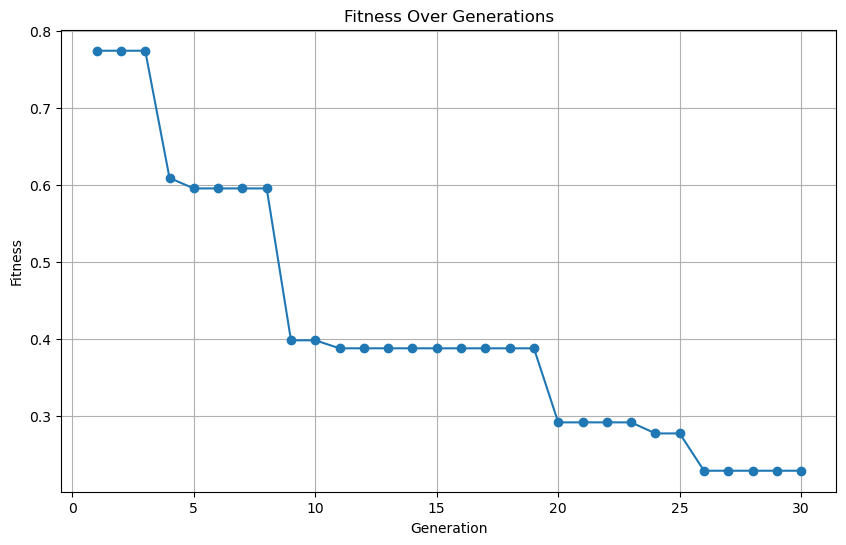

In [1187]:
# plotting results
plot_fitness_history(fitness_history)

`First Time`

After running this section a couple of times, we see 2 frequent scenarios:

- Scenario 1: Graphs converge somewhat quickly or drops are acentuated: This is represented by big drops in fitness from generation to generation especially in early ones and after this a plateau which suggests the model didn't improve as expected. This could mean that the GA found a balanced league early on or, most likely, found a local optimum and had a hard time leaving, indicating that mutation and crossover might not be exploring much new territory. Initial parameters were crossover_rate=0.5, mutation_rate=0.1, selection_mechanism is picked at random from the two choices.
- Approach 1: We wanted to encourage progressive convergence so we increased the crossover (initially 0.4) and mutation (initially 0.1) rates to possibly add diversity and new exploration.


- Scenario 2: Graphs show progressive convergence: Even in the cases where the initial fitness is high, meaning there was a significant imbalance between teams af first, the updates are still continual small drops. In some cases, we can see noticeable improvements around early-mid generations which means that the algorithm might be finding an local optimum, but generally it is still able to keep improving. There is a good amount of variability introduced by our algorithm.
- Approach 2: Improve even further rates so that convergence happens more steadily over generations.

`Tuned Approach`

- Outcome: Results show improvements as graphs display progressive convergence. Parameters were updated to crossover_rate=0.7, mutation_rate=0.3. Fitness drops are gradual and happen over generations for most cases, which is the desired output.

In [1149]:
# example of a optimized league configuration
describe_league(best_solution)


League Fitness: 0.0571

Team 0 (Avg Rating: 86.43, Total Cost: 680.00)
  GK  - Alex Carter     | Rating: 85  | Cost: 90
  DEF - Caleb Fisher    | Rating: 84  | Cost: 85
  DEF - Mason Reed      | Rating: 82  | Cost: 75
  MID - Dylan Morgan    | Rating: 91  | Cost: 115
  MID - Dominic Bell    | Rating: 86  | Cost: 95
  FWD - Julian Scott    | Rating: 92  | Cost: 130
  FWD - Adrian Collins  | Rating: 85  | Cost: 90

Team 1 (Avg Rating: 86.29, Total Cost: 692.00)
  GK  - Blake Henderson | Rating: 87  | Cost: 95
  DEF - Lucas Bennett   | Rating: 85  | Cost: 90
  DEF - Maxwell Flores  | Rating: 81  | Cost: 72
  MID - Spencer Ward    | Rating: 84  | Cost: 85
  MID - Austin Torres   | Rating: 82  | Cost: 80
  FWD - Sebastian Perry | Rating: 95  | Cost: 150
  FWD - Xavier Bryant   | Rating: 90  | Cost: 120

Team 2 (Avg Rating: 86.43, Total Cost: 667.00)
  GK  - Jordan Smith    | Rating: 88  | Cost: 100
  DEF - Daniel Foster   | Rating: 90  | Cost: 110
  DEF - Jaxon Griffin   | Rating: 79  | Co

##### ``Final League Configuration``

In this section, we wanted to run our GA multiple times in order to find the best optimal solution. The code appears commented because with every run, the final league configuration might not be the best and we wanted to preserve the best solution we got after all the runs. The code can be uncommented for use and will print a summary of the multiple GA Loop runs as well as the final configuration for the league. Our best results yielded a configuration that had a fitness value of `0.0571` which was a good outcome.

Running GA, Run 1 of 20...
Generation 1: Best Fitness = 0.8051
Error during crossover_random_mix: Total: 100. Cannot fill FWD in team 3 within budget.
[Fallback] random_mix_crossover failed - cloning a parent.

Fitness before mutation: 0.8349508112115694
Fitness after mutation: 0.844671171376828
Sucessful swap between Team 2 and Team 1 at position MID.
Sucessful swap between Team 4 and Team 3 at position GK.
Generation 2: Best Fitness = 0.5813
Swap successful between Team 4 and Team 0 at positions FWD and MID.
Teams 3 and 1 already have similar costs. No mutation.
Generation 3: Best Fitness = 0.5813
Generation 4: Best Fitness = 0.5813
Sucessful swap between Team 0 and Team 3 at position DEF.
Generation 5: Best Fitness = 0.5813
Generation 6: Best Fitness = 0.5813
Swap successful between Team 4 and Team 3 at positions FWD and GK.
Sucessful swap between Team 2 and Team 3 at position FWD.
Generation 7: Best Fitness = 0.4371

Fitness before mutation: 0.4729412959213412
Fitness after mutatio

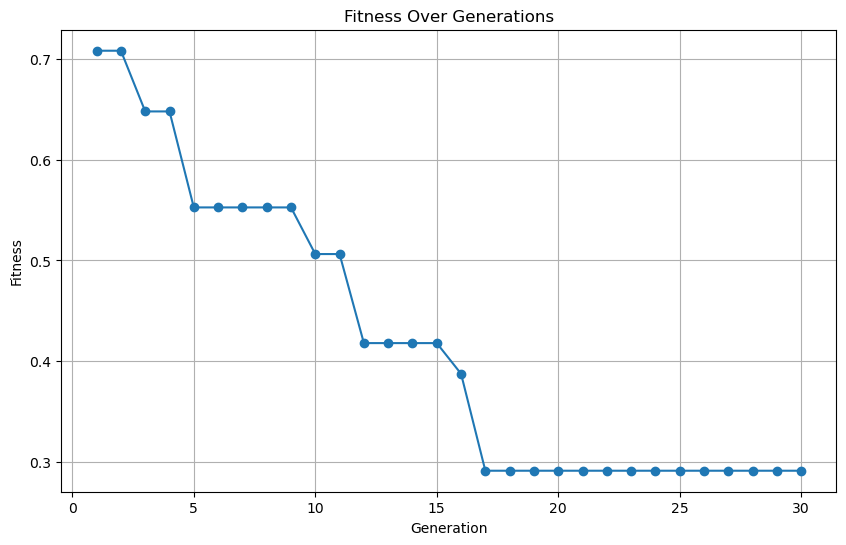


League Fitness: 0.0571

Team 0 (Avg Rating: 86.43, Total Cost: 690.00)
  GK  - Blake Henderson | Rating: 87  | Cost: 95
  DEF - Lucas Bennett   | Rating: 85  | Cost: 90
  DEF - Jaxon Griffin   | Rating: 79  | Cost: 65
  MID - Ashton Phillips | Rating: 90  | Cost: 110
  MID - Austin Torres   | Rating: 82  | Cost: 80
  FWD - Elijah Sanders  | Rating: 93  | Cost: 140
  FWD - Landon Powell   | Rating: 89  | Cost: 110

Team 1 (Avg Rating: 86.43, Total Cost: 662.00)
  GK  - Jordan Smith    | Rating: 88  | Cost: 100
  DEF - Brayden Hughes  | Rating: 87  | Cost: 100
  DEF - Mason Reed      | Rating: 82  | Cost: 75
  MID - Connor Hayes    | Rating: 89  | Cost: 105
  MID - Bentley Rivera  | Rating: 88  | Cost: 100
  FWD - Zachary Nelson  | Rating: 86  | Cost: 92
  FWD - Adrian Collins  | Rating: 85  | Cost: 90

Team 2 (Avg Rating: 86.29, Total Cost: 680.00)
  GK  - Ryan Mitchell   | Rating: 83  | Cost: 85
  DEF - Daniel Foster   | Rating: 90  | Cost: 110
  DEF - Logan Brooks    | Rating: 86  | 

In [ ]:
'''
def run_ga_multiple_times(players, num_runs, population_size=5, generations=30, crossover_rate=0.7, mutation_rate=0.3):
    """Runs GA algorithm num_runs times to find optimal solution."""
    best_solution = None
    best_fitness = float(999)  # initialize as a large number so that any fitness will be better
    best_fitness_history = []

    for run in range(num_runs):
        print(f"Running GA, Run {run + 1} of {num_runs}...")
        # run GA once and get the best solution and fitness history
        solution, fitness_history = genetic_algorithm(players, population_size, generations, crossover_rate, mutation_rate)
        
        # check if this run produced a better solution
        current_best_fitness = min(fitness_history) 

        if current_best_fitness < best_fitness:
            best_fitness = current_best_fitness
            best_solution = solution
            best_fitness_history = fitness_history  # store the best fitness history

    plot_fitness_history(fitness_history)

    return best_solution, best_fitness, best_fitness_history

# run test (20 runs)
best_solution, best_fitness, best_fitness_history = run_ga_multiple_times(players, num_runs=20)
describe_league(best_solution)
'''

In [ ]:
'''
def export_to_csv(solution, filename="final_league_configuration.csv"):
    """Exports final league configuration to csv file."""
    data = []

    for team_key, team in solution.population.items():
        for pos_players in team.values():
            for player in pos_players:
                player_id, skill, position, salary = player
                data.append({
                    "Name": player_id,
                    "Skill": skill,
                    "Position": position,
                    "Salary": salary,
                    "Team": team_key
                })

    df = pd.DataFrame(data, columns=["Name", "Skill", "Position", "Salary", "Team"])
    df.to_csv(filename, index=False)
    print(f"✅ Final league configuration exported to {filename}")

export_to_csv(best_solution)
'''

✅ Final league configuration exported to final_league_configuration.csv


# Comparing with other algorithms

##### `Hill Climbing`

This is a simple, local search algorithm used to solve optimization problems. The main idea is to iteratively improve a solution by making local changes, with the goal of finding a better (usually global) optimal solution.
- max_iterations: The maximum number of times the algorithm will run.
- stagnation_limit: The number of iterations without improvement after which the algorithm stops early.

In [1156]:
def hill_climbing(players, max_iterations=1000, stagnation_limit=100):
    '''Performs hill climbing optimization to find a solution for the sports league.'''
    # initialize and store fitness
    current = TeamAssignmentSolution(players) 
    current.random_initial_representation()
    current_fitness = current.fitness()
    
    # tracking best solution
    best_solution = copy.deepcopy(current)
    best_fitness = current_fitness
    fitness_history = [best_fitness]

    stagnation_counter = 0

    for iteration in range(max_iterations):
        # small mutation
        neighbor = copy.deepcopy(current)
        mutation_method = random.choice([
            mutate_swap_same_position,
            skill_balance_mutation,
            mutate_swap_two_players,
            mutate_swap_based_on_cost
        ])
        mutation_method(neighbor)

        neighbor_fitness = neighbor.fitness()

        # accept the new solution if it's better (lower fitness)
        if neighbor_fitness < current_fitness:
            current = neighbor
            current_fitness = neighbor_fitness
            if current_fitness < best_fitness:
                best_solution = copy.deepcopy(current)
                best_fitness = current_fitness
                stagnation_counter = 0
        else:
            stagnation_counter += 1 # track improvements

        fitness_history.append(best_fitness)

        # logging fitnesses
        # print(f"Iteration {iteration + 1}: Best Fitness = {best_fitness:.4f}")

        # if no improvements are happening, stop early
        if stagnation_counter >= stagnation_limit:
            print(f"[Stopped early] No improvement in last {stagnation_limit} iterations.")
            break

    return best_solution, fitness_history

##### `Simulated Annealing`

Simulated Annealing is a probabilistic optimization algorithm inspired by the physical process of heating and then slowly cooling a material to decrease defects, thereby minimizing the system's energy. It’s often used for optimization problems where the search space is large and contains many local minima. The algorithm uses a "temperature" parameter that controls how much the algorithm allows for exploring worse solutions (higher energy). At the beginning of the process, the temperature is high, allowing the algorithm to accept worse solutions. Over time, the temperature decreases, and the algorithm becomes more conservative.
- initial_temp: The initial "temperature" that controls the probability of accepting worse solutions.
- cooling_rate: The rate at which the temperature cools down after each iteration.
- min_temp: The minimum allowable temperature before the algorithm stops.

`Metropolis Criterion` is a decision rule used in Simulated Annealing to decide whether to accept a worse solution when exploring the search space. The basic idea of the Metropolis criterion is to introduce a probabilistic acceptance for solutions that are worse than the current one, which allows the algorithm to escape local optima and explore the search space more effectively, especially in the early stages of optimization. As the algorithm progresses, the likelihood of accepting worse solutions decreases, focusing more on exploiting the best solution found so far. (exp(−ΔE/T), where ΔE is the difference in fitness and T the temperature.)

In [1157]:
def simulated_annealing(players, initial_temp=100.0, cooling_rate=0.95, min_temp=0.01, max_iterations=1000):
    '''Performs the simulated annealing optimization algorithm to find an optimal sports league.'''

    # initial solution
    current_solution = TeamAssignmentSolution(players)
    current_solution.random_initial_representation()
    current_fitness = current_solution.fitness()

    # track best solution
    best_solution = copy.deepcopy(current_solution)
    best_fitness = current_fitness

    fitness_history = [current_fitness]
    temp = initial_temp # auxiliary variable to manipulate temperature

    for iteration in range(max_iterations):
        if temp < min_temp: # if the temperature reached min limit, no further improvements can be made
            break

        # generate a neighbor (mutate current solution slightly)
        neighbor = copy.deepcopy(current_solution)
        mutation = random.choice([
            mutate_swap_same_position,
            skill_balance_mutation,
            mutate_swap_two_players,
            mutate_swap_based_on_cost
        ])
        mutation(neighbor)
        neighbor_fitness = neighbor.fitness()

        # decision criteria
        delta = neighbor_fitness - current_fitness # difference between solutions fitness (if neighbor is better, delta will be negative)

        # if solution is better always accept it
        # if solution is worse accept with the metropolis criterion
        if delta < 0 or random.random() < math.exp(-delta / temp):
            current_solution = neighbor
            current_fitness = neighbor_fitness

            if current_fitness < best_fitness:
                best_solution = copy.deepcopy(current_solution)
                best_fitness = current_fitness

        fitness_history.append(best_fitness)
        temp *= cooling_rate  # cool down temperature

        if iteration % 100 == 0 or iteration == max_iterations - 1: # printing every 100 iterations
            print(f"[SA] Iteration {iteration}: Best Fitness = {best_fitness:.4f}")

    return best_solution, fitness_history

##### `Results (HC & SA)`

These are the results for a random initial configuration using the 'Hill Climbing' and 'Simulated Annealing' algorithms.

In [1159]:
# run hill climbing
hc_solution, hc_history = hill_climbing(players)
hc_fitness = hc_solution.fitness()
# run simmulated annealing
sa_solution, sa_history = simulated_annealing(players)
sa_fitness = sa_solution.fitness()

Mutation failed: Swap would exceed the budget for one of the teams.
Sucessful swap between Team 3 and Team 4 at position DEF.
Sucessful swap between Team 1 and Team 2 at position GK.
Sucessful swap between Team 4 and Team 3 at position FWD.

Fitness before mutation: 1.0117674976929016
Fitness after mutation: 0.8962506937918961
Sucessful swap between Team 0 and Team 4 at position MID.
Swap successful between Team 3 and Team 2 at positions MID and GK.
Swap successful between Team 4 and Team 0 at positions FWD and MID.
Sucessful swap between Team 3 and Team 2 at position MID.
Teams 2 and 4 already have similar costs. No mutation.
Swap successful between Team 2 and Team 4 at positions DEF and GK.
Sucessful swap between Team 2 and Team 3 at position FWD.
Teams 0 and 4 already have similar costs. No mutation.
Swap successful between Team 2 and Team 3 at positions DEF and GK.
Teams 2 and 1 already have similar costs. No mutation.

Fitness before mutation: 0.7137140569598166
Fitness after muta

Hill Climbing Best Fitness    : 0.0571
Simulated Annealing Fitness   : 0.1895


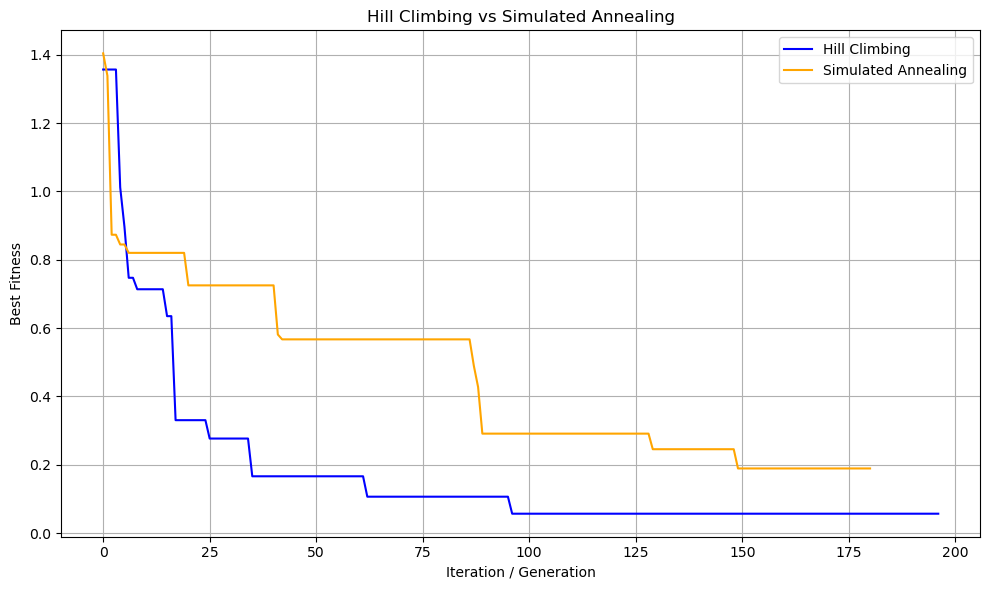

In [1160]:
# fitness results
print(f"Hill Climbing Best Fitness    : {hc_fitness:.4f}")
print(f"Simulated Annealing Fitness   : {sa_fitness:.4f}")

# plotting fitness history line graphs
plt.figure(figsize=(10, 6))
plt.plot(hc_history, label="Hill Climbing", color="blue")
plt.plot(sa_history, label="Simulated Annealing", color="orange")
plt.xlabel("Iteration / Generation")
plt.ylabel("Best Fitness")
plt.title("Hill Climbing vs Simulated Annealing")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Interpretation:** Results here vary, for some of the iterations we have significant drops where as for other sections we can see a gradual decrease of the fitness indicating that we are exploring new options more conservatively. In general, even if the algorithms start from an initially high fitness configuration, it still manages to sucessfully decrease the variance of average skill rating between teams within the same league without ever showing an increase, which is ideally what would happen. We made sure which we made sure to implement this, especially for hill climbing which is famous for getting stuck at local optima.

# Final Evaluation

To evaluate the results of our implementation of a genetic algorithm agains other optimization approaches, we will generate an random initial configuration and pass it as an argument for all the algorithms. Since our GA loop takes in a population of leagues instead of a single league configuration, we will simply clone the same league for the number of times equal to the length of the population and use this as a starting point. This way they all start from the same point ensuring fairness.

In [1161]:
def generate_initial_configuration(players):
    '''Creates a random instance of our TeamAssignmentSolution Class.'''
    
    initial_solution = TeamAssignmentSolution(players)
    initial_solution.random_initial_representation()
    return initial_solution

This section will have versions of our optimization algorithms where the only change is that they take in the argument `initial_solution` to ensure we are comparing results in a fair way - genetic_algorithm_eval, hill_climbing_eval and simulated_annealing_eval.

In [1162]:
# GA
def genetic_algorithm_eval(players, initial_solution, population_size=5, generations=100, crossover_rate=0.7, mutation_rate=0.3):
    population = []
    for _ in range(population_size):
        sol = copy.deepcopy(initial_solution)  # use the same initial configuration
        population.append(sol)

    # initializing fitness history
    fitness_history = []
    best_solution = None
    best_fitness = float(999)  # initialing with a very big number

    # iterating trough generations
    for generation in range(generations):
        population.sort(key=lambda sol: sol.fitness()) # apply elitism - best solutions first
        new_population = [] # create new population - that will undergo selection, crossover, mutations

        # track best solution across all generations
        current_best = population[0] # initialize at the first instance
        current_fitness = current_best.fitness()
        if current_fitness < best_fitness:
            best_fitness = current_fitness
            best_solution = copy.deepcopy(current_best) # store a copy of the best 

        fitness_history.append(best_fitness) # store fitness
        print(f"Generation {generation + 1}: Best Fitness = {current_fitness:.4f}")

        while len(new_population) < population_size:
            # selection approach
            selection_method = random.choice([ranking_selection, tournament_selection])
            parent1 = selection_method(population)
            parent2 = selection_method(population)
            
            # crossover approach
            if random.random() < crossover_rate:
                crossover_method = random.choice([crossover_best_avg_skill, crossover_random_mix])
                offspring = crossover_method(parent1, parent2, players)
            else:
                offspring = random.choice([parent1, parent2]) # randomly choose between parents

            # mutation approach
            if random.random() < mutation_rate:
                mutation_method = random.choice([
                    mutate_swap_same_position,
                    skill_balance_mutation,
                    mutate_swap_two_players,
                    mutate_swap_based_on_cost
                ])
                mutation_method(offspring)

            new_population.append(offspring)

        population = new_population

    return best_solution, fitness_history

# HC
def hill_climbing_eval(players, initial_solution, max_iterations=1000, stagnation_limit=100):
    current = copy.deepcopy(initial_solution)  # same  initial configuration
    current_fitness = current.fitness()

    # tracking best solution
    best_solution = copy.deepcopy(current)
    best_fitness = current_fitness
    fitness_history = [best_fitness]

    stagnation_counter = 0

    for iteration in range(max_iterations):
        # small mutation
        neighbor = copy.deepcopy(current)
        mutation_method = random.choice([
            mutate_swap_same_position,
            skill_balance_mutation,
            mutate_swap_two_players,
            mutate_swap_based_on_cost
        ])
        mutation_method(neighbor)

        neighbor_fitness = neighbor.fitness()

        # accept the new solution if it's better (lower fitness)
        if neighbor_fitness < current_fitness:
            current = neighbor
            current_fitness = neighbor_fitness
            if current_fitness < best_fitness:
                best_solution = copy.deepcopy(current)
                best_fitness = current_fitness
                stagnation_counter = 0
        else:
            stagnation_counter += 1 # track improvements

        fitness_history.append(best_fitness)

        # logging fitnesses
        # print(f"Iteration {iteration + 1}: Best Fitness = {best_fitness:.4f}")

        # if no improvements are happening, stop early
        if stagnation_counter >= stagnation_limit:
            print(f"[Stopped early] No improvement in last {stagnation_limit} iterations.")
            break

    return best_solution, fitness_history

# SA
def simulated_annealing_eval(players, initial_solution, initial_temp=100.0, cooling_rate=0.95, min_temp=0.01, max_iterations=1000):
    current_solution = copy.deepcopy(initial_solution) # same initial configuration
    current_fitness = current_solution.fitness()

    # track best solution
    best_solution = copy.deepcopy(current_solution)
    best_fitness = current_fitness

    fitness_history = [current_fitness]
    temp = initial_temp # auxiliary variable to manipulate temperature

    for iteration in range(max_iterations):
        if temp < min_temp: # if the temperature reached min limit, no further improvements can be made
            break

        # generate a neighbor (mutate current solution slightly)
        neighbor = copy.deepcopy(current_solution)
        mutation = random.choice([
            mutate_swap_same_position,
            skill_balance_mutation,
            mutate_swap_two_players,
            mutate_swap_based_on_cost
        ])
        mutation(neighbor)
        neighbor_fitness = neighbor.fitness()

        # decision criteria
        delta = neighbor_fitness - current_fitness # difference between solutions fitness (if neighbor is better, delta will be negative)

        # if solution is better always accept it
        # if solution is worse accept with the metropolis criterion
        if delta < 0 or random.random() < math.exp(-delta / temp):
            current_solution = neighbor
            current_fitness = neighbor_fitness

            if current_fitness < best_fitness:
                best_solution = copy.deepcopy(current_solution)
                best_fitness = current_fitness

        fitness_history.append(best_fitness)
        temp *= cooling_rate  # cool down temperature

        if iteration % 100 == 0 or iteration == max_iterations - 1: # printing every 100 iterations
            print(f"[SA] Iteration {iteration}: Best Fitness = {best_fitness:.4f}")

    return best_solution, fitness_history

In [1207]:
def compare_algorithms(players, num_runs=10):
    '''Compares perfomance of optimization algorithms.'''
    
    # generate common initial configuration 
    initial_solution = generate_initial_configuration(players)

    # store finess
    ga_fitness_history = []
    hc_fitness_history = []
    sa_fitness_history = []

    for _ in range(num_runs):
        ga_solution, ga_history = genetic_algorithm_eval(players, initial_solution)
        ga_fitness_history.append(ga_history)
        hc_solution, hc_history = hill_climbing_eval(players, initial_solution)
        hc_fitness_history.append(hc_history)
        sa_solution, sa_history = simulated_annealing_eval(players, initial_solution)
        sa_fitness_history.append(sa_history)

    # average fitness history (see how they perform overall over the 10 runs)
    avg_ga_fitness_history = [sum(x) / len(x) for x in zip(*ga_fitness_history)]
    avg_hc_fitness_history = [sum(x) / len(x) for x in zip(*hc_fitness_history)]
    avg_sa_fitness_history = [sum(x) / len(x) for x in zip(*sa_fitness_history)]

    # plotting fitness history
    plt.figure(figsize=(10, 6))
    plt.plot(avg_ga_fitness_history, label='Genetic Algorithm (GA)', color='blue')
    plt.plot(avg_hc_fitness_history, label='Hill Climbing (HC)', color='orange')
    plt.plot(avg_sa_fitness_history, label='Simulated Annealing (SA)', color='green')
    plt.xlabel('Iterations / Generations')
    plt.ylabel('Best Fitness (Lower is Better)')
    plt.title('Fitness History Comparison of Optimization Algorithms')
    plt.legend()
    plt.show()

    # store best fitness for each algorithm
    ga_best_fitness = min(avg_ga_fitness_history)
    hc_best_fitness = min(avg_hc_fitness_history)
    sa_best_fitness = min(avg_sa_fitness_history)

    # fitness summary
    print("\nFitness Summary:")
    print(f"Genetic Algorithm (GA) - Best Fitness: {ga_best_fitness:.4f}")
    print(f"Hill Climbing (HC) - Best Fitness: {hc_best_fitness:.4f}")
    print(f"Simulated Annealing (SA) - Best Fitness: {sa_best_fitness:.4f}")

    return avg_ga_fitness_history, avg_hc_fitness_history, avg_sa_fitness_history

Generation 1: Best Fitness = 0.4642
Sucessful swap between Team 3 and Team 1 at position DEF.
Generation 2: Best Fitness = 0.4642
Sucessful swap between Team 3 and Team 0 at position MID.

Fitness before mutation: 0.4642307659791949
Fitness after mutation: 0.7362342129557204
Sucessful swap between Team 2 and Team 3 at position GK.
Generation 3: Best Fitness = 0.4642

Fitness before mutation: 0.33073819722257536
Fitness after mutation: 0.3307381972225753
Sucessful swap between Team 2 and Team 0 at position DEF.
Generation 4: Best Fitness = 0.3307

Fitness before mutation: 0.4642307659791949
Fitness after mutation: 0.8962506937918916
Sucessful swap between Team 2 and Team 3 at position FWD.
Teams 0 and 4 already have similar costs. No mutation.
Generation 5: Best Fitness = 0.3307
Generation 6: Best Fitness = 0.3307

Fitness before mutation: 0.4642307659791949
Fitness after mutation: 0.3875617133214431
Sucessful swap between Team 2 and Team 3 at position DEF.
Generation 7: Best Fitness = 

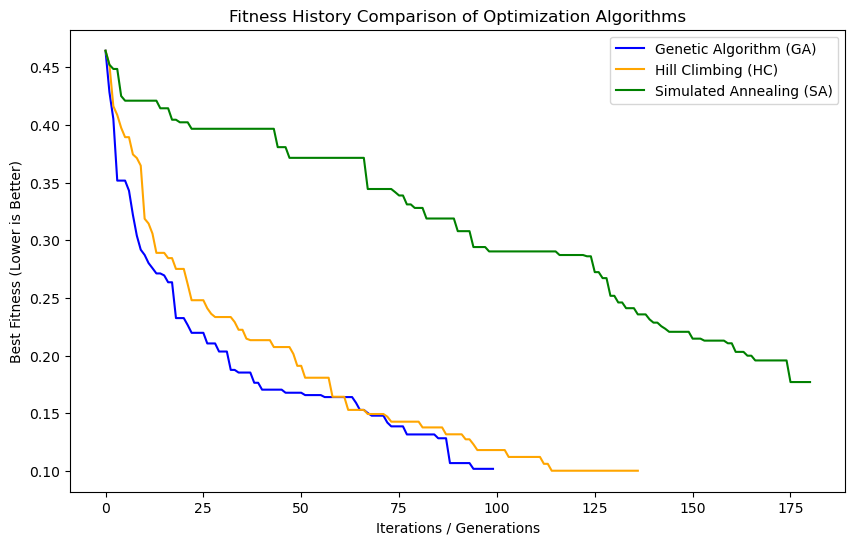


Fitness Summary:
Genetic Algorithm (GA) - Best Fitness: 0.1019
Hill Climbing (HC) - Best Fitness: 0.1003
Simulated Annealing (SA) - Best Fitness: 0.1771


In [1209]:
avg_ga_fitness_history, avg_hc_fitness_history, avg_sa_fitness_history = compare_algorithms(players, num_runs=10)

**Conclusion:** All algorithms are doing really well, being able to steadily decrease the fitness value for each league configuration solution which is exactly what we want for our minimization problem. Our GA usually performs the best being able to get to the lowest fitness possible in the lowest number of iterations.